In [1]:
from math import cos, log, pi, sqrt

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [2]:
# 1. Random number generator

# 1.a
def BoxMuller(mean, var):
    # y = x*sigma + var
    # => y = sqrt(-2*ln(a)) * cos(2*pi*b) * sigma + mu
    a = np.random.uniform()
    b = np.random.uniform()
    sigma = np.sqrt(var)

    y = sqrt(-2 * log(a)) * cos(2 * pi * b) * sigma + mean
    return y


def printGaussianDist(mean, var):
    Gaussian = []
    for i in range(10000):
        Gaussian.append(BoxMuller(mean, var))
    plt.hist(Gaussian, 100)
    # plt.savefig("Gaussian")
    plt.show()
    plt.clf()

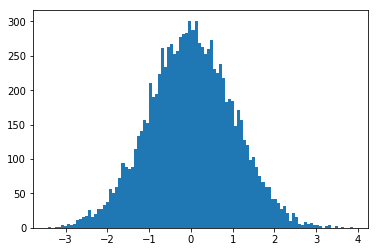

<Figure size 432x288 with 0 Axes>

In [3]:
printGaussianDist(0, 1)

In [4]:
# 1.b
def polyBasis(n, a, w):
    e = BoxMuller(mean=0, var=a)
    x = np.random.uniform(-1, 1)
    polyFunc = np.polynomial.polynomial.Polynomial(w)
    y = polyFunc(x) + e
    return [x, y]


def printPolyBasis(n, a, w):
    x = []
    y = []
    for _ in range(10000):
        res = polyBasis(n, a, w)
        x.append(res[0])
        y.append(res[1])
    plt.xlim(-2, 2)
    plt.ylim(-20, 30)
    plt.scatter(x, y)
    # plt.savefig("Poly")
    plt.show()
    plt.clf()

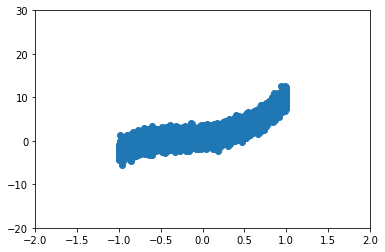

<Figure size 432x288 with 0 Axes>

In [5]:
printPolyBasis(4, 1, [1, 2, 3, 4])

In [6]:
# 2. Sequential Estimator


def WelfordEstimate(mean, var):  # Using online algorithm
    logStack = []
    print("Data point source function: N(%f, %f)\n" % (mean, var))
    Xbar = 0
    prev_Xbar = 1
    sigma = 0
    prev_Sigma = 1
    iters = 1
    while abs(Xbar - prev_Xbar) >= 10 ** -3 or abs(sigma - prev_Sigma) >= 10 ** -3:
        # set a maximum iteration
        if iters > 10000:
            break

        newData = BoxMuller(mean, var)
        # initial condition
        if iters == 1:
            Xbar = newData
            sigma = 0
        else:
            prev_Xbar = Xbar
            prev_Sigma = sigma
            Xbar = prev_Xbar + (newData - prev_Xbar) / iters
            sigma = prev_Sigma + ((newData - prev_Xbar) * (newData - Xbar) - prev_Sigma) / iters
        # Output log
        if iters % 200 == 0:
            logStack.append([iters, newData, Xbar, sigma])
        iters += 1
    logStack.append([iters, newData, Xbar, sigma])  # final result
    for i in range(len(logStack)):
        print("[%d] Add data point: %f" % (logStack[i][0], logStack[i][1]))
        print("Mean = %f, Variance = %f" % (logStack[i][2], logStack[i][3]))

$$\bar{x}_n = \bar{x}_{n-1} + \frac{x_n - \bar{x}_{n-1}}{n}$$
$$\sigma^2_n = \sigma^2_{n-1} + \frac{(x_n - \bar{x}_{n-1})(x_n - \bar{x}_n) - \sigma^2_{n-1}}{n}$$

In [7]:
WelfordEstimate(3, 5)

Data point source function: N(3.000000, 5.000000)

[200] Add data point: 7.036159
Mean = 2.866428, Variance = 5.207938
[400] Add data point: 1.051201
Mean = 2.880393, Variance = 5.355235
[600] Add data point: -0.184479
Mean = 3.012700, Variance = 5.410978
[800] Add data point: 3.874254
Mean = 2.983524, Variance = 5.071312
[1000] Add data point: 0.932381
Mean = 2.958012, Variance = 5.320836
[1200] Add data point: 1.265285
Mean = 2.940177, Variance = 5.266424
[1400] Add data point: 3.867096
Mean = 2.969564, Variance = 5.212513
[1600] Add data point: 3.004858
Mean = 2.965642, Variance = 5.179693
[1800] Add data point: 0.230998
Mean = 2.954803, Variance = 5.073138
[1874] Add data point: 1.158737
Mean = 2.966532, Variance = 5.083601


In [8]:
# 3. Baysian Linear regression


def drawPredDist(a, C, w):
    n = len(w)
    X = np.linspace(-2, 2)
    var_log = []
    for x in X:
        vecX = np.array([[x ** i for i in range(n)]])  # build X
        pred_var = 1 / a + np.dot(vecX.dot(np.linalg.inv(C)), vecX.T)
        var_log.append(pred_var[0][0])
    return np.array(var_log)


def printPrediction(iters, inX, inY, post_mean, post_cov, pred_mean, pred_var):
    print("[%d] Add data point: (%f, %f) " % (iters, inX, inY))
    print("\nPosterior mean:")
    print(post_mean)
    print("\nPosterior variance:")
    print(post_cov)
    print("\nPredictive distribution ~ N(%f, %f)" % (pred_mean, pred_var))
    print("--------------------------------------------------")


def plotLine(title, idx, w, var):
    plt.subplot(2, 2, idx)
    plt.title(title, fontsize=22)
    plt.xlim(-2, 2)
    plt.ylim(-20, 30)
    X = np.linspace(-2, 2)
    polyFunc = np.polynomial.polynomial.Polynomial(w)
    plt.plot(X, polyFunc(X), "k", linewidth=3)
    plt.plot(X, polyFunc(X) + var, "r", linewidth=3)
    plt.plot(X, polyFunc(X) - var, "r", linewidth=3)


def BLR(b, n, a, w, log=True):
    # init
    iters = 0
    incomeData = [[], []]
    prior_cov = np.identity(n)  # arbitrary value
    prior_mean = np.zeros((n, 1))  # 0s
    posterior_cov = None
    posterior_mean = None
    X = None
    y = None
    converge = False

    while True:
        # set maximum iters=10000
        if iters >= 10000:
            break
        iters += 1
        # New data incoming:
        incomeX, incomeY = polyBasis(n, a, w)  # new data comes from ground truth
        incomeData[0].append(incomeX)
        incomeData[1].append(incomeY)

        if iters == 1:
            X = np.array([[incomeX ** i for i in range(n)]])
            y = np.array([[incomeY]])
        else:
            X = np.concatenate((X, [[incomeX ** i for i in range(n)]]))
            y = np.concatenate((y, [[incomeY]]))

        prev_cov = posterior_cov
        vecX = np.array([[incomeX ** i for i in range(n)]])

        # COV^-1 (C) = (aX^TX + bI)^-1
        # mu = aC^-1X^Ty
        C = a * X.T.dot(X) + b * np.identity(n)
        posterior_cov = np.linalg.inv(C)
        posterior_mean = a * np.dot(np.linalg.inv(C), X.T).dot(y)
        

        # save mu for iter=10 and 50
        if iters == 10:
            mu_10 = posterior_mean
        if iters == 50:
            mu_50 = posterior_mean

        # Predictive distribution
        # mean = Xu
        # var = 1/a + XC^-1X^T
        pred_mean = vecX.dot(posterior_mean)[0]
        pred_var = 1 / a + np.dot(vecX.dot(np.linalg.inv(C)), vecX.T)

        if iters == 10:
            var_10 = drawPredDist(a, C, posterior_mean)
        if iters == 50:
            var_50 = drawPredDist(a, C, posterior_mean)

        # check if converge
        converge = True
        if iters > 100:
            sub_cov = posterior_cov - prev_cov
            for rows in sub_cov:
                for item in rows:
                    if abs(item) > 10 ** -4:
                        converge = False
                        break
            if converge == True:
                break

        # Print log
        if iters % 50 == 0 and log == True:
            printPrediction(
                iters, incomeX, incomeY, posterior_mean, posterior_cov, pred_mean, pred_var
            )
        # update prior
        prior_cov = posterior_cov
        prior_mean = posterior_mean

    # Print predict result
    if log == True:
        printPrediction(iters, incomeX, incomeY, posterior_mean, posterior_cov, pred_mean, pred_var)

    # --- Print result: ---
    plt.figure(figsize=(12, 9))
    # Plot ground truth:
    plotLine("Ground truth", 1, w, a)

    # Plot After 10 incomes
    plotLine("After 10 incomes", 3, mu_10.flatten(), var_10)
    plt.scatter(incomeData[0][:10], incomeData[1][:10])

    # Plot After 50 incomes
    plotLine("After 50 incomes", 4, mu_50.flatten(), var_50)
    plt.scatter(incomeData[0][:50], incomeData[1][:50])

    # Plot predict result
    var_res = drawPredDist(a, C, posterior_mean)
    plotLine("Predict Result", 2, posterior_mean.flatten(), var_res)
    plt.scatter(incomeData[0][:], incomeData[1][:])

[50] Add data point: (0.340282, 1.587900) 

Posterior mean:
[[1.39735727]
 [2.90220208]
 [1.69721097]
 [2.47931738]]

Posterior variance:
[[ 0.03554761 -0.01144608 -0.05139312  0.01116472]
 [-0.01144608  0.19802084  0.00642751 -0.23187057]
 [-0.05139312  0.00642751  0.17082867 -0.00543908]
 [ 0.01116472 -0.23187057 -0.00543908  0.39645798]]

Predictive distribution ~ N(2.679136, 1.036810)
--------------------------------------------------
[100] Add data point: (-0.830486, 0.016613) 

Posterior mean:
[[1.11049997]
 [2.62324231]
 [2.6210912 ]
 [3.02464857]]

Posterior variance:
[[ 0.01938738 -0.00650582 -0.03105743  0.00728267]
 [-0.00650582  0.12619514  0.007165   -0.16382675]
 [-0.03105743  0.007165    0.10339198 -0.00309886]
 [ 0.00728267 -0.16382675 -0.00309886  0.28624764]]

Predictive distribution ~ N(-0.992776, 1.047522)
--------------------------------------------------
[150] Add data point: (-0.236969, 1.631137) 

Posterior mean:
[[1.1440737 ]
 [2.72870423]
 [2.48326514]
 [3.014

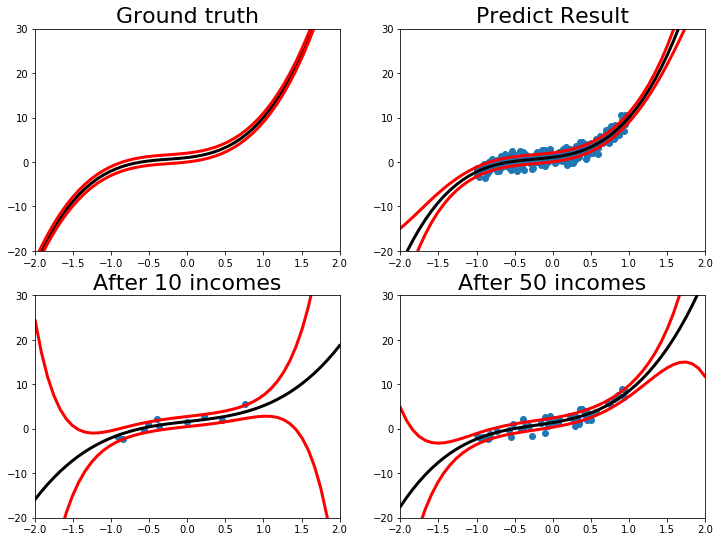

In [12]:
%%time
# case 1. b = 1, n = 4, a = 1, w = [1, 2, 3, 4]
BLR(1, 4, 1, [1, 2, 3, 4], log=True)

Wall time: 72.8 ms


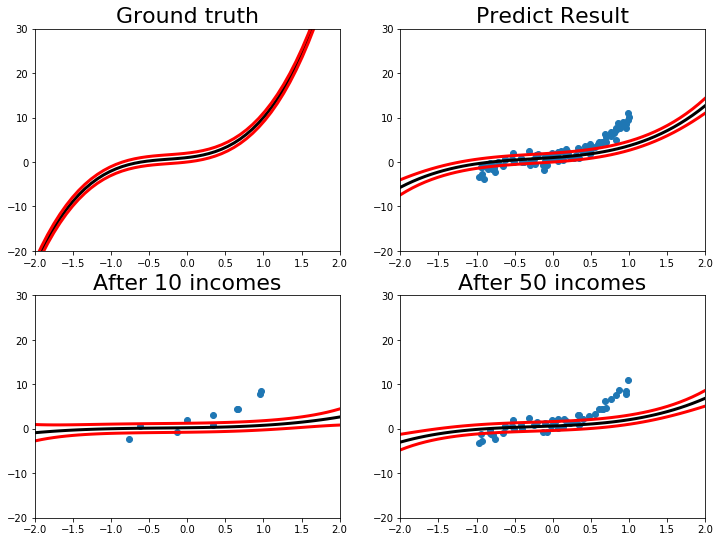

In [10]:
%%time
# case 2. b = 100, n = 4, a = 1, w = [1, 2, 3, 4]
BLR(100, 4, 1, [1, 2, 3, 4], log=False)

Wall time: 72.8 ms


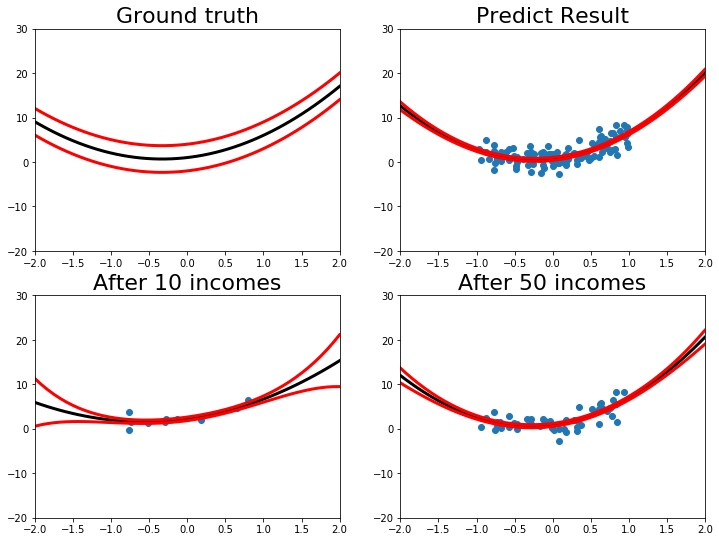

In [11]:
%%time
# case 3. b = 1, n = 3, a = 3, w = [1, 2, 3]
BLR(1, 3, 3, [1, 2, 3], log=False)